## Quick Approach to Question/Answer Classification.

This is a first attempt to build a classification model that would distinguish between questions and answers on StackOverflow based on the textual data only.

In [1]:
import numpy as np
import pandas as pd
import os
import bq_helper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
from sklearn.decomposition import TruncatedSVD

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

Using TensorFlow backend.


In [66]:
import keras

In [5]:
from IPython.display import Image

In [6]:
from bs4 import BeautifulSoup

In [7]:
# create a helper object for this dataset
stack_overflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [ ]:
stack_overflow.list_tables()

In [ ]:
stack_overflow.head('posts_questions')

In [ ]:
### Query for extracting all questions from 2018

qu_all_questions = """
SELECT body
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE EXTRACT(YEAR FROM creation_date)=2018;
"""

In [ ]:
df_all_question_2018 = stack_overflow.query_to_pandas_safe(qu_all_questions, max_gb_scanned=24)

In [ ]:
df_all_question_2018.head()

In [8]:
# load existing dataset with all questions from 2018
df_all_question_2018 = pd.read_csv('../input/stackoverflow/all_stackoverflow_questions_with_time_to_answer_2018.csv', usecols=['body'])

In [ ]:
# set id as an index
df_all_question_2018.set_index('id', inplace=True)

In [9]:
df_all_question_2018.head()

,body
0,<p>I attempted to create a program that opens ...
1,<p>I've just finished my last android project ...
2,<p>I have an object organization that contains...
3,<p>I have a YAML file i.e. <code>test.yml</cod...
4,<p>I want to transform this algorithm in pytho...


In [10]:
"""
This is a query to extract answers data that correspond to
the first answers to 2018 questions.
"""
qu_earliest_ans_body = """
WITH answers_table AS
(
SELECT 
    a.parent_id AS que_id,
    a.creation_date AS ans_date,
    a.body AS ans_body
FROM
    `bigquery-public-data.stackoverflow.posts_answers` AS a
INNER JOIN `bigquery-public-data.stackoverflow.posts_questions` AS q
ON q.id=a.parent_id
WHERE
    a.parent_id IN (SELECT id FROM `bigquery-public-data.stackoverflow.posts_questions` 
    WHERE EXTRACT(YEAR FROM creation_date)=2018)
)
SELECT 
       ans_body 
FROM
answers_table
WHERE
CONCAT(CAST(que_id AS STRING), CAST(ans_date AS STRING))  IN 
    (SELECT CONCAT(CAST(que_id AS STRING), CAST(MIN(ans_date) AS STRING)) FROM answers_table GROUP BY que_id);
"""

In [11]:
df_answers = stack_overflow.query_to_pandas_safe(qu_earliest_ans_body, max_gb_scanned=21)

In [12]:
df_answers.head()

,ans_body
0,<pre><code>var rnd = new Random();\nvar random...
1,<p>I've worked around this by overriding SendT...
2,"<p>You can use <a href=""https://docs.python.or..."
3,<p>As per you comment you want to register a G...
4,"<p>yes it is possible, you just have to return..."


In [ ]:
len(df_answers), len(df_answers.que_id.unique())

In [ ]:
df_answers.que_id.value_counts().head()

In [ ]:
# one collision on answer date is observed
df_answers[df_answers.que_id==51490721]

In [ ]:
df_all_question_2018.head()

In [ ]:
# sanity check
(df_answers.ans_date.isin(df_all_question_2018.first_ans_date)).sum()

### Building Classification Model

#### Constructing features and labels

We will vectorize the texts based on TF-iDF vectorizer:

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=1000, max_df=1.e6, token_pattern=r'(?u)\b[A-Za-z]+\b')

In [ ]:
vectorizer

In [ ]:
len(df_all_question_2018), len(df_answers)

In [ ]:
X_que_ans = vectorizer.fit_transform(np.concatenate([df_all_question_2018.body, df_answers.ans_body]))

In [ ]:
X_que_ans.shape

In [ ]:
print(vectorizer.get_feature_names()[:1000])

In [ ]:
# 0 will stand for questions , and 1 will stand for answers
y_que_ans = np.concatenate([np.zeros(len(df_all_question_2018.body)), np.ones(len(df_answers.ans_body))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_que_ans, y_que_ans, test_size=0.33, random_state=42)

In [ ]:
y_que_ans.shape[0]

In [ ]:
X_train_ix, X_test_ix, y_train_ix, y_test_ix = train_test_split(np.arange(X_que_ans.shape[0]), np.arange(X_que_ans.shape[0]), 
                                                                test_size=0.33, random_state=42)

In [ ]:
#X_test_ix

#### Neural Net approach with Keras

Let's build a neural net with 2 hidden layers, 1 input layer and 1 output layer. Parameter `input_dim` should corresond to number of dimensions in our TFiDF matrix:

In [ ]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=10083))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

In [ ]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)

In [ ]:
loss_and_metrics

In [ ]:
y_test_pred = model.predict_classes(X_test)

In [ ]:
accuracy_score(y_test, y_test_pred), precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

In [ ]:
accuracy_score(y_test, y_test_pred), precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

In [ ]:
query_text = """I am trying to figure out what's the best way to solve this problem. And I'm stuck."""

In [ ]:
answer_text = """I have found this solution for you. It should work!"""

In [ ]:
X_ans = vectorizer.transform([answer_text])

In [ ]:
X_ = vectorizer.transform([query_text])

In [ ]:
X_.shape

In [ ]:
model.predict(X_)

In [ ]:
model.predict(X_ans)

In [ ]:
body_test = np.concatenate([df_all_question_2018.body, df_answers.ans_body])[X_test_ix]

In [ ]:
body_test.shape, X_test.shape

In [ ]:
X_body_test = vectorizer.transform(body_test)

In [ ]:
X_body_test != X_test

In [ ]:
X_body_test.shape, X_test.shape

In [ ]:
(X_body_test[-1].todense() == X_test[-1].todense()).mean()

In [ ]:
y_body_test = y_que_ans[y_test_ix]

In [ ]:
y_body_test_pred = model.predict_classes(X_body_test)

In [ ]:
accuracy_score(y_body_test, y_body_test_pred), precision_score(y_body_test, y_body_test_pred), recall_score(y_body_test, y_body_test_pred)

In [ ]:
y_body_test_pred, y_test_pred

### Error Analysis

In [ ]:
plot_model(model, to_file='QA_classifier_NeuralNet.png')

In [ ]:
plot_model(model)

In [ ]:
ls

In [ ]:
Image('QA_classifier_NeuralNet.png')

### Another iteration in feature engineering

1. Remove a content of 'code' html-tags in questions and answers.
2. Try LSA technique for feature engineering? (try SVD - see snippet below)
3. Try different NN architecture.
4. Perform Error analysis.
5. Is there any way to remove technical words as they don't contribute much to the Q/A classification?

In [ ]:
>>> 
>>> 
>>> svd_topic_vectors = svd.fit_transform(tfidf_docs.values)

In [14]:
df_all_question_2018.body.str.len().mean(), df_answers.ans_body.str.len().mean()

(1658.70097311638, 920.8964727103199)

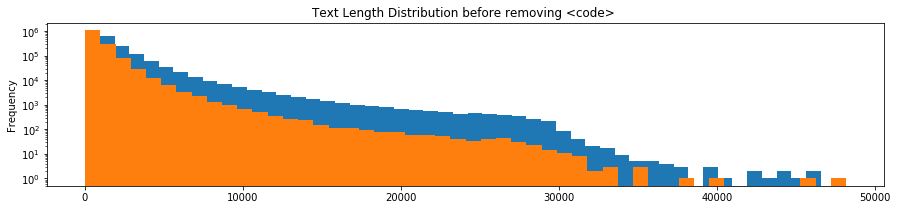

In [19]:
df_all_question_2018.body.str.len().plot(kind='hist', bins=50, logy=True, figsize=(15, 3))
df_answers.ans_body.str.len().plot(kind='hist', bins=50, logy=True, figsize=(15, 3), title='Text Length Distribution before removing <code> ')

In [25]:
df_all_question_2018.body.str.len().mean(), df_answers.ans_body.str.len().mean()

(521.0989347286039, 352.20168481909684)

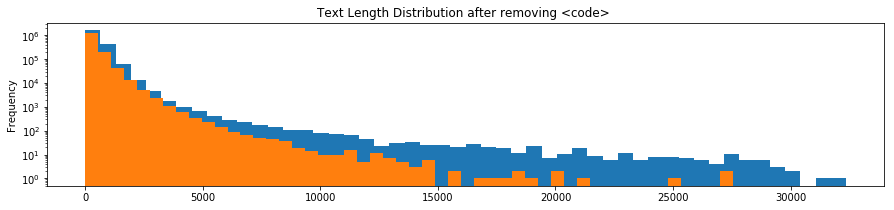

In [24]:
df_all_question_2018.body.str.len().plot(kind='hist', bins=50, logy=True, figsize=(15, 3))
df_answers.ans_body.str.len().plot(kind='hist', bins=50, logy=True, figsize=(15, 3), title='Text Length Distribution after removing <code> ')

In [21]:
def remove_code_tags(body_text):
    soup = BeautifulSoup(body_text, "html.parser")
    for match in soup.find_all('code'):
        match.decompose()
    return soup.text

In [22]:
df_all_question_2018['body'] = df_all_question_2018.body.apply(remove_code_tags)

In [23]:
df_answers['ans_body'] = df_answers.ans_body.apply(remove_code_tags)

In [ ]:
df_all_question_2018.clear_body.iloc[7]

In [73]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=1000, max_df=1.e6, token_pattern=r'(?u)\b[A-Za-z]+\b')

In [74]:
X_all = vectorizer.fit_transform(np.concatenate([df_all_question_2018.body, df_answers.ans_body]))

In [75]:
X_all.shape

(3708192, 6179)

In [76]:
print(vectorizer.get_feature_names()[:1000])

['aa', 'aad', 'ab', 'abc', 'ability', 'able', 'abort', 'aborted', 'absence', 'absolute', 'absolutely', 'abstract', 'abstraction', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accesses', 'accessibility', 'accessible', 'accessing', 'accessor', 'accidentally', 'accommodate', 'accomplish', 'accomplished', 'according', 'accordingly', 'accordion', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'achieve', 'achieved', 'achieving', 'achive', 'acl', 'acquire', 'act', 'acting', 'action', 'actions', 'activate', 'activated', 'activating', 'activation', 'active', 'actively', 'activerecord', 'activities', 'activity', 'actor', 'acts', 'actual', 'actually', 'ad', 'adapt', 'adapted', 'adapter', 'adb', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'additions', 'addon', 'address', 'addressed', 'addresses', 'addressing', 'adds', 'adjacent', 'adjust', 'adjusted', 'adjusting', 'adjustments', 'admin', 'administration', 'administrator', 

In [31]:
# 0 will stand for questions , and 1 will stand for answers
y_all = np.concatenate([np.zeros(len(df_all_question_2018.body)), np.ones(len(df_answers.ans_body))])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

### Model for new feature set:

In [78]:
model = Sequential()
model.add(Dense(units=82, activation='elu', input_dim=6179))
model.add(Dense(units=82, activation='elu'))
model.add(Dense(units=82, activation='elu'))
model.add(Dense(units=1, activation='sigmoid'))

In [79]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['binary_accuracy'])

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 82)                506760    
_________________________________________________________________
dense_19 (Dense)             (None, 82)                6806      
_________________________________________________________________
dense_20 (Dense)             (None, 82)                6806      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 83        
Total params: 520,455
Trainable params: 520,455
Non-trainable params: 0
_________________________________________________________________


In [81]:
history_train = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.25)

Train on 1863366 samples, validate on 621122 samples
Epoch 1/10
1863366/1863366 [==============================] - 268s 144us/step - loss: 0.3048 - binary_accuracy: 0.8685 - val_loss: 0.2795 - val_binary_accuracy: 0.8813
Epoch 2/10
1863366/1863366 [==============================] - 269s 144us/step - loss: 0.2735 - binary_accuracy: 0.8832 - val_loss: 0.2730 - val_binary_accuracy: 0.8825
Epoch 3/10
1863366/1863366 [==============================] - 268s 144us/step - loss: 0.2657 - binary_accuracy: 0.8865 - val_loss: 0.2631 - val_binary_accuracy: 0.8878
Epoch 4/10
1863366/1863366 [==============================] - 268s 144us/step - loss: 0.2590 - binary_accuracy: 0.8901 - val_loss: 0.2590 - val_binary_accuracy: 0.8906
Epoch 5/10
1863366/1863366 [==============================] - 268s 144us/step - loss: 0.2543 - binary_accuracy: 0.8925 - val_loss: 0.2556 - val_binary_accuracy: 0.8915
Epoch 6/10
1863366/1863366 [==============================] - 268s 144us/step - loss: 0.2497 - binary_accur

In [83]:
history_train.history

{'val_loss': [0.2795220029664593,
  0.27301879795179984,
  0.26311571474420187,
  0.25896739553160536,
  0.255551601779105,
  0.254103727384108,
  0.2580640260021909,
  0.25016949472323236,
  0.24586308995773912,
  0.24527726675313516],
 'val_binary_accuracy': [0.8812552123415368,
  0.882469144548092,
  0.8877756704801956,
  0.8905867124333062,
  0.8914915266243991,
  0.891673455456416,
  0.8910664893531384,
  0.89456499689272,
  0.8960816071560821,
  0.8962055763601998],
 'loss': [0.30479938933739215,
  0.2734784050128042,
  0.26565729202204846,
  0.2589747878951685,
  0.2542952053206491,
  0.24972369124663624,
  0.24563274218490078,
  0.2421381988773223,
  0.23896954795450134,
  0.2360127729392809],
 'binary_accuracy': [0.8684531111976928,
  0.8832408662603053,
  0.8864887520754811,
  0.8901192787675637,
  0.8924736203194216,
  0.8944023879366054,
  0.8963161289837213,
  0.8980683344013571,
  0.8996176811211539,
  0.9008455665713986]}

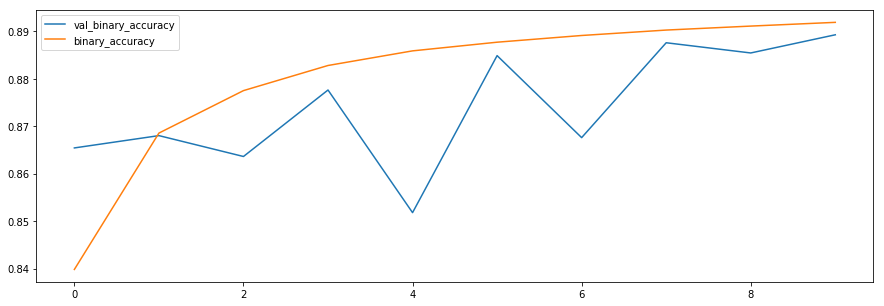

In [58]:
# Plot training & validation accuracy values
pd.DataFrame(history_train.history)[['val_binary_accuracy', 'binary_accuracy']].plot(figsize=(15, 5))

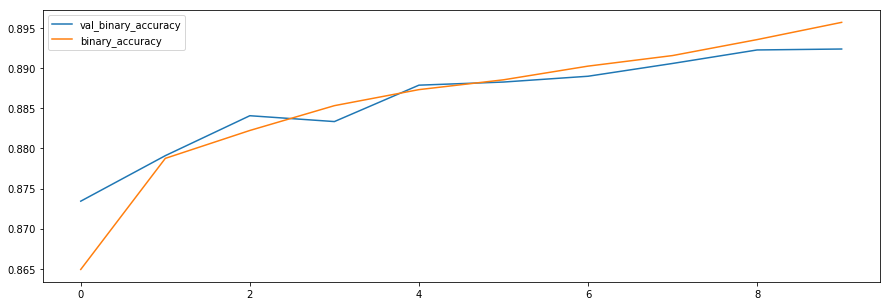

In [70]:
# Plot training & validation accuracy values
pd.DataFrame(history_train.history)[['val_binary_accuracy', 'binary_accuracy']].plot(figsize=(15, 5))

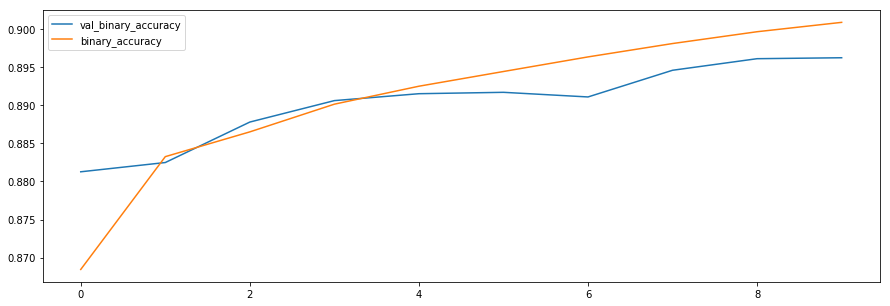

In [82]:
# Plot training & validation accuracy values
pd.DataFrame(history_train.history)[['val_binary_accuracy', 'binary_accuracy']].plot(figsize=(15, 5))

In [84]:
y_test_pred = model.predict_classes(X_test)

In [42]:
accuracy_score(y_test, y_test_pred), precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.8860263593156515, 0.8245045735054641, 0.9222514997357164)

In [72]:
accuracy_score(y_test, y_test_pred), precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.8923244510110289, 0.8941494164465104, 0.8406065357627774)

In [85]:
accuracy_score(y_test, y_test_pred), precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.8966441230885901, 0.8794513697896204, 0.8708507966824058)

### SVD Feature Transform

In [ ]:
svd = TruncatedSVD(n_components=300, n_iter=100)

In [ ]:
len(df_answers)

In [ ]:
df_all_question_2018['body'] = df_all_question_2018.body.apply(remove_code_tags)

In [ ]:
df_answers['body'] = df_answers.ans_body.apply(remove_code_tags)

In [ ]:
# code tags removed
X_all_svd = svd.fit(vectorizer.fit_transform(np.concatenate([df_all_question_2018.body, df_answers.body])))